# Sample Sihouette Coefficient
* Using micro and macro averaging.
* Using two sampling strategies, one per aggregation type.

In [1]:
from sklearn.metrics import silhouette_samples
import pandas as pd
import numpy as np

import numpy as np
np.random.seed=42

def control_sample(X, clustering, balanced=False, sample_size=-1):
    """
    Sample data points from the dataset based on the specified strategy.

    This function samples data points based on the sample strategy:
    - 'uniform': Randomly samples 'sample_size' number of rows from the entire dataset.
    - 'balanced': Samples a specified number of rows per cluster.

    Parameters:
    X (array-like): 2D array-like structure with the coordinates of the data points.
    clustering (array-like): Cluster labels for the data points.
    balanced (bool): If True, samples a specified number of rows per cluster.
                     If False, samples 'sample_size' number of rows uniformly from the entire dataset.
    sample_size (int): Total number of samples to draw. If sample_size is less than 1, the entire dataset is returned.

    Returns:
    tuple: Two arrays, one with the sampled data points and another with the corresponding cluster labels.
    """
    if sample_size < 1:
        return X, clustering

    X = np.array(X)
    clustering = np.array(clustering)

    if not balanced:
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        return X[indices], clustering[indices]

    # Otherwise: sample n rows per cluster
    unique_clusters, counts = np.unique(clustering, return_counts=True)
    samples_per_cluster = max(1, sample_size // len(unique_clusters))

    sampled_X = []
    sampled_clustering = []

    for cluster in unique_clusters:
        cluster_indices = np.where(clustering == cluster)[0]
        sample_indices = np.random.choice(cluster_indices, size=min(len(cluster_indices), samples_per_cluster), replace=False)
        sampled_X.append(X[sample_indices])
        sampled_clustering.append(clustering[sample_indices])

    sampled_X = np.vstack(sampled_X)
    sampled_clustering = np.hstack(sampled_clustering)

    return sampled_X, sampled_clustering


class SampleSilhouette:

  def __init__(self, X, clustering, sample_size=-1, sample_strategy='micro'):
    self.X, self.clustering = control_sample(X, clustering, balanced=sample_strategy=='macro', sample_size=sample_size)
    self.point_sil = pd.DataFrame({'sil': silhouette_samples(self.X, self.clustering), 'label':self.clustering})


  def macro(self):
    """
    Macro-averaged silhouette, for per-cluster averaging, then returning their mean
    :return: the silhouette aggregated score
    """
    representatives = self.point_sil.groupby('label').sil.apply(np.mean)
    return representatives.mean()

  def micro(self):
    """
    Micro-averaged silhouette, as in sklearn
    :return: the silhouette aggregated score
    """
    return self.point_sil.sil.mean()

# Assessing KMeans using micro/macro-averaged Silhouette

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

# Function to generate initial clusters
def generate_initial_clusters(n_clusters, points_per_cluster, variance):
    centers = np.random.uniform(-10, 10, (n_clusters, 2))
    X = []
    y_labels = []
    for i, (cx, cy) in enumerate(centers):
        cluster_points = np.random.normal(loc=[cx, cy], scale=variance, size=(points_per_cluster, 2))
        X.append(cluster_points)
        y_labels.append(np.full(points_per_cluster, i))
    
    X = np.vstack(X)
    y_labels = np.hstack(y_labels)
    return X, y_labels, centers

# Function to add points to one cluster without increasing its diameter
def add_points_to_cluster(X, y_labels, cluster_index, additional_points, variance):
    cluster_points = X[y_labels == cluster_index]
    new_points = np.random.normal(loc=np.mean(cluster_points, axis=0), scale=variance, size=(additional_points, 2))
    X = np.vstack([X, new_points])
    y_labels = np.hstack([y_labels, np.full(additional_points, cluster_index)])
    return X, y_labels

# Parameters
n_clusters = 4
points_per_cluster = 100
variance = 0.5
additional_points = 500
cluster_to_expand = 1
cluster_names = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D']

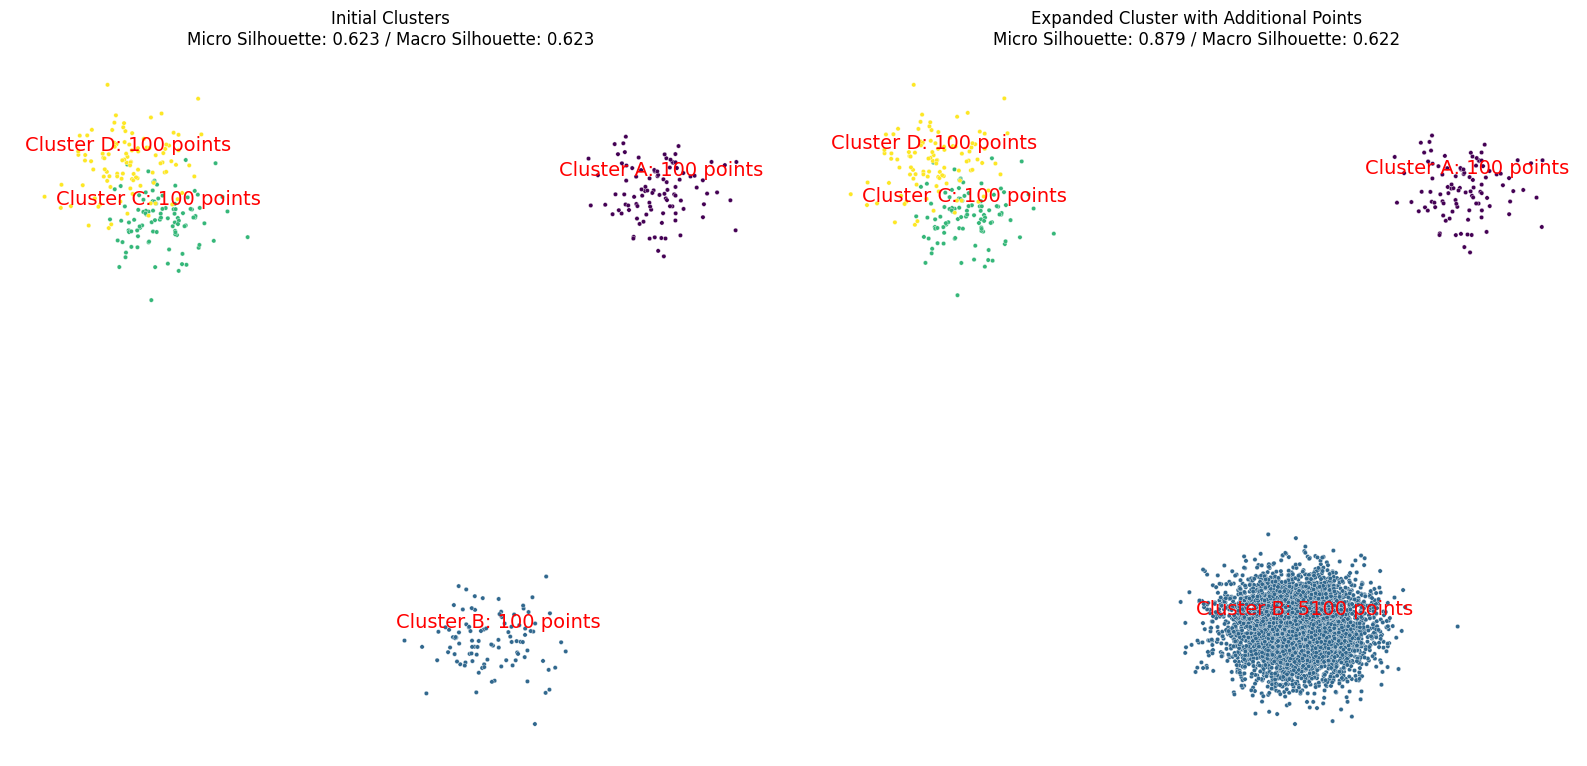

In [66]:
# Generate initial clusters
X, y_labels, centers = generate_initial_clusters(n_clusters, points_per_cluster, variance)

# Compute the Silhouette Scores for the initial clusters
initial_silhouette = SampleSilhouette(X, y_labels)
initial_micro_silhouette_score = initial_silhouette.micro()
initial_macro_silhouette_score = initial_silhouette.macro()

# Visualize initial clusters
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title(f'Initial Clusters\nMicro Silhouette: {initial_micro_silhouette_score:.3f} / Macro Silhouette: {initial_macro_silhouette_score:.3f}')
for i, (cx, cy) in enumerate(centers):
    points_in_cluster = sum(y_labels == i)
    plt.annotate(f'{cluster_names[i]}: {points_in_cluster} points', (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=14, color='red')
plt.tight_layout()
plt.axis('off')
sns.despine(left=True, bottom=True)

# Add points to one of the clusters
X_expanded, y_labels_expanded = add_points_to_cluster(X, y_labels, cluster_to_expand, additional_points, variance)

# Compute the Silhouette Scores for the expanded clusters
expanded_silhouette = SampleSilhouette(X_expanded, y_labels_expanded)
expanded_micro_silhouette_score = expanded_silhouette.micro()
expanded_macro_silhouette_score = expanded_silhouette.macro()

# Visualize expanded clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_expanded[:, 0], y=X_expanded[:, 1], hue=y_labels_expanded, palette='viridis', s=10, legend=None)
plt.title(f'Expanded Cluster with Additional Points\nMicro Silhouette: {expanded_micro_silhouette_score:.3f} / Macro Silhouette: {expanded_macro_silhouette_score:.3f}')
for i, (cx, cy) in enumerate(centers):
    points_in_cluster = sum(y_labels_expanded == i)
    plt.annotate(f'{cluster_names[i]}: {points_in_cluster} points', (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=14, color='red')
plt.tight_layout()
plt.axis('off')
sns.despine(left=True, bottom=True)

plt.savefig('expanded_clusters.jpg', format='JPG', dpi=300)
plt.show()

In [78]:
x_mic, x_mac, added_points = [], [], range(100, 5000, 100)
for ap in added_points:
    X_expanded_grad, y_labels_expanded_grad = add_points_to_cluster(X, y_labels, cluster_to_expand, ap, variance)
    expanded_silhouette_grad = SampleSilhouette(X_expanded_grad, y_labels_expanded_grad)
    x_mic.append(expanded_silhouette_grad.micro())
    x_mac.append(expanded_silhouette_grad.macro())

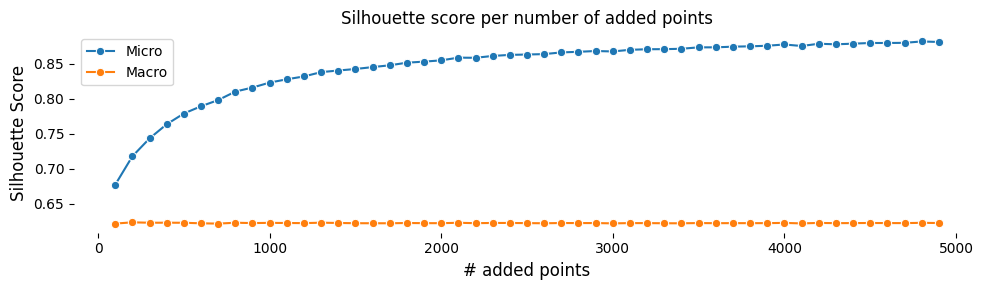

In [87]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=added_points, y=x_mic, marker='o', label='Micro')
sns.lineplot(x=added_points, y=x_mac, marker='o', label='Macro')
plt.legend()
plt.xlabel('# added points', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette score per number of added points')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('expanded_clusters_ts.jpg', format='JPG', dpi=300)
plt.show()

# Topology and Micro v Macro
* When the cluster we add points to is close to others, the micro drops. 
* That is different to the previous example, with the distant major cluster, where micro increased.

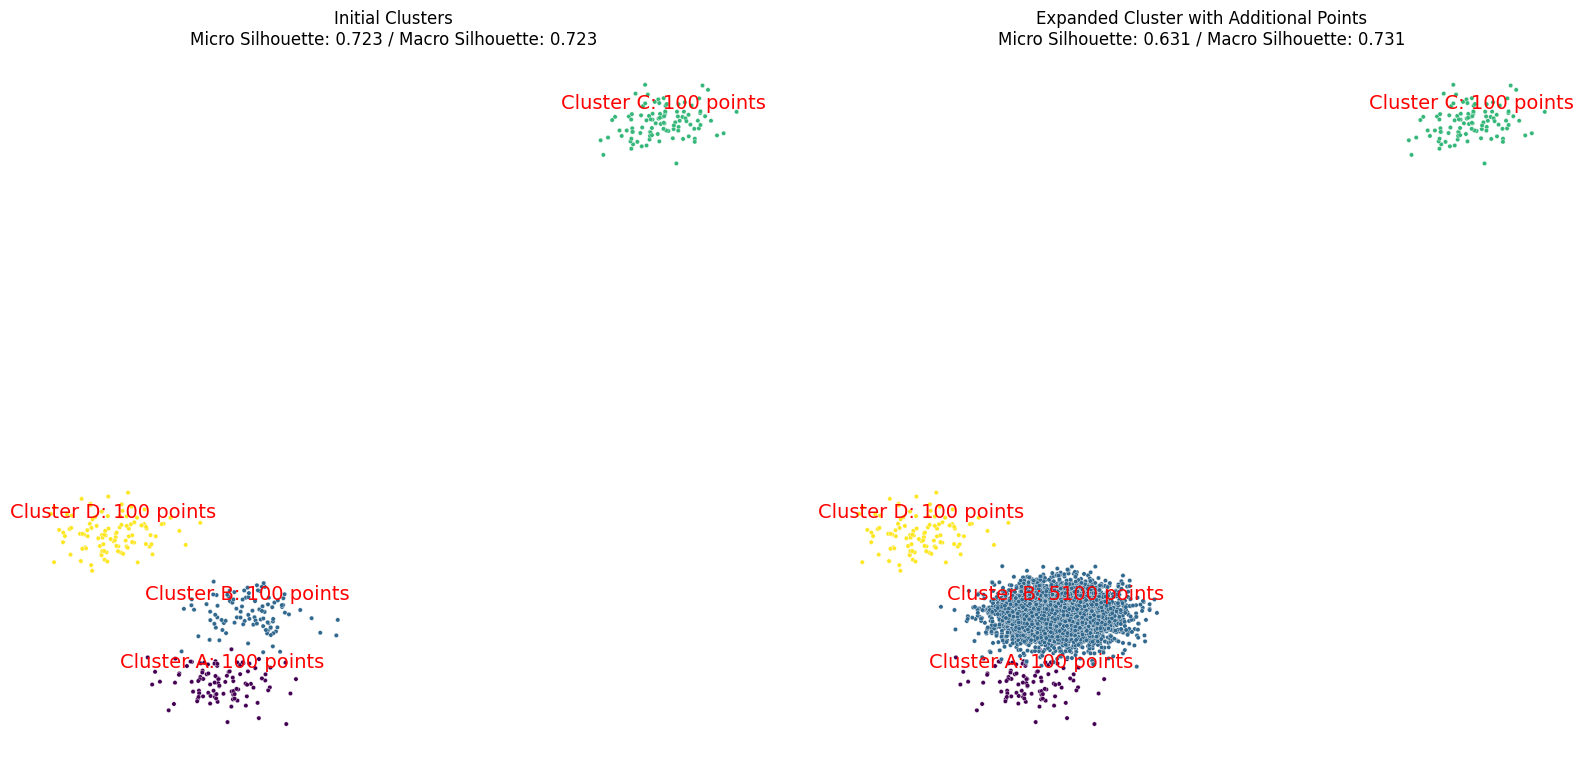

In [207]:
n_clusters = 4
points_per_cluster = 100
variance = 0.5
additional_points = 5000
cluster_to_expand = 1
cluster_names = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D']

# Generate initial clusters
X, y_labels, centers = generate_initial_clusters(n_clusters, points_per_cluster, variance)

# Compute the Silhouette Scores for the initial clusters
initial_silhouette = SampleSilhouette(X, y_labels)
initial_micro_silhouette_score = initial_silhouette.micro()
initial_macro_silhouette_score = initial_silhouette.macro()

# Visualize initial clusters
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y_labels, palette='viridis', s=10, legend=None)
plt.title(f'Initial Clusters\nMicro Silhouette: {initial_micro_silhouette_score:.3f} / Macro Silhouette: {initial_macro_silhouette_score:.3f}')
for i, (cx, cy) in enumerate(centers):
    points_in_cluster = sum(y_labels == i)
    plt.annotate(f'{cluster_names[i]}: {points_in_cluster} points', (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=14, color='red')
plt.tight_layout()
plt.axis('off')
sns.despine(left=True, bottom=True)

# Add points to one of the clusters
X_expanded, y_labels_expanded = add_points_to_cluster(X, y_labels, cluster_to_expand, additional_points, variance)

# Compute the Silhouette Scores for the expanded clusters
expanded_silhouette = SampleSilhouette(X_expanded, y_labels_expanded)
expanded_micro_silhouette_score = expanded_silhouette.micro()
expanded_macro_silhouette_score = expanded_silhouette.macro()

# Visualize expanded clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_expanded[:, 0], y=X_expanded[:, 1], hue=y_labels_expanded, palette='viridis', s=10, legend=None)
plt.title(f'Expanded Cluster with Additional Points\nMicro Silhouette: {expanded_micro_silhouette_score:.3f} / Macro Silhouette: {expanded_macro_silhouette_score:.3f}')
for i, (cx, cy) in enumerate(centers):
    points_in_cluster = sum(y_labels_expanded == i)
    plt.annotate(f'{cluster_names[i]}: {points_in_cluster} points', (cx, cy), textcoords="offset points", xytext=(0,10), ha='center', fontsize=14, color='red')
plt.tight_layout()
plt.axis('off')
sns.despine(left=True, bottom=True)

plt.savefig('expanded_clusters_forNMI.jpg', format='JPG', dpi=300)
plt.show()

# Estimating $k$ in synthetic spaces
* Α random space is created of three balanced clusters and one considerably larger.
* KMeans is trained for varying $k$ and the number that yields the optimal micro/macro Silhouette is selected.

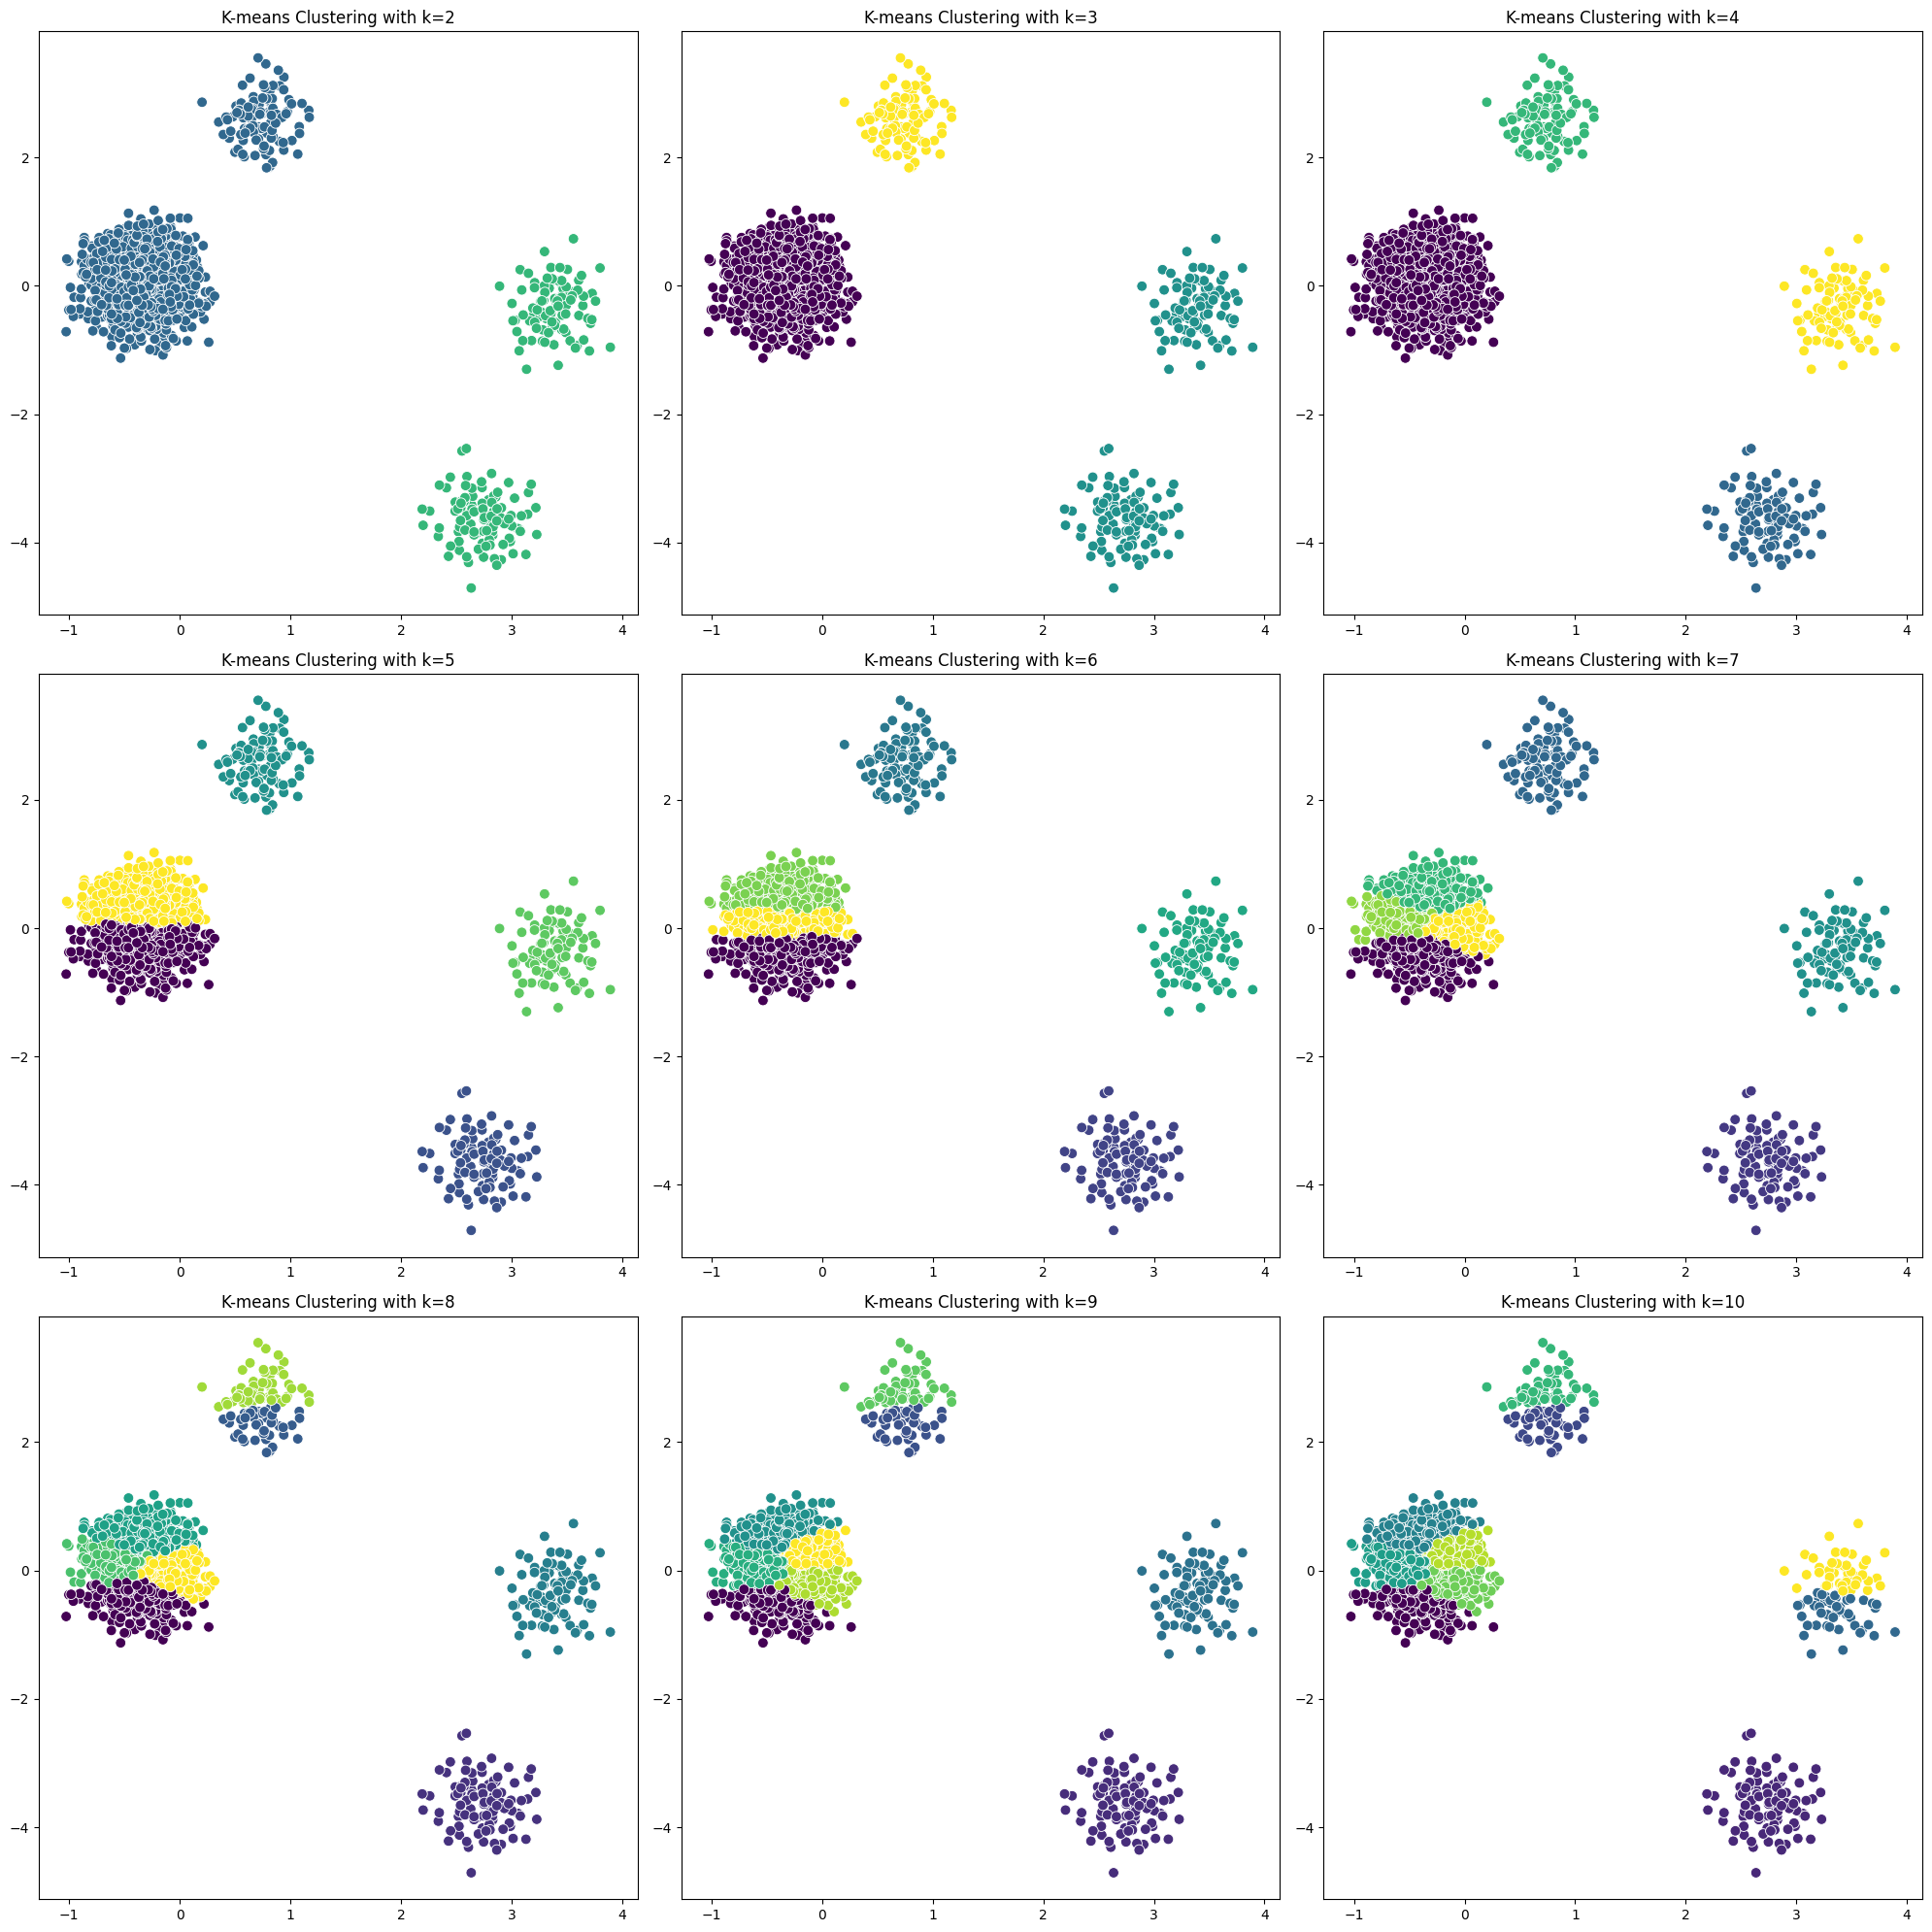

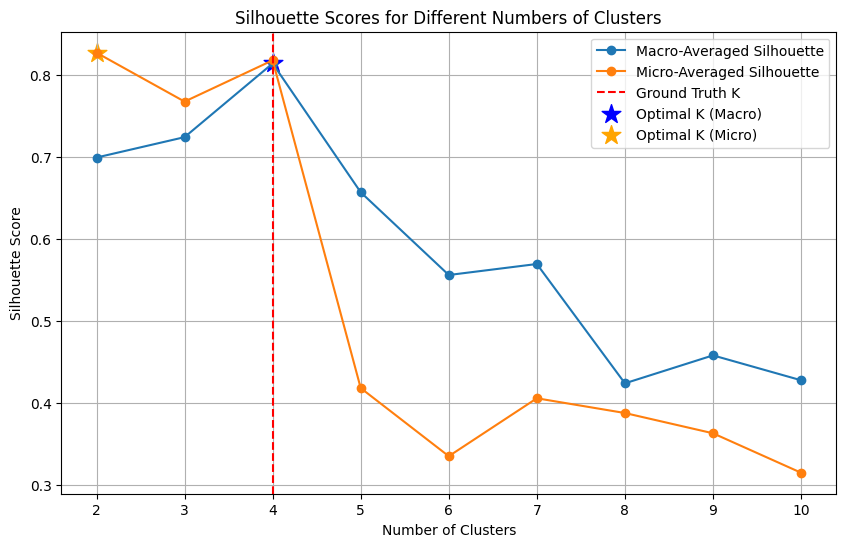

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Function to generate imbalanced synthetic datasets
def generate_imbalanced_synthetic_data(n_samples=500, n_features=2, centers=4, cluster_sizes=[100, 200, 50, 150], random_state=None):
    X, y = [], []
    current_label = 0
    for i, size in enumerate(cluster_sizes):
        X_blob, y_blob = make_blobs(n_samples=size, n_features=n_features, centers=1, cluster_std=1.0, random_state=random_state+i)
        X.append(X_blob)
        y.append(np.full(size, current_label))
        current_label += 1
    
    X = np.vstack(X)
    y = np.hstack(y)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Function to find the optimal number of clusters using silhouette method
def find_optimal_clusters(X, max_clusters=10):
    mas, mis, kmeans_labels_list = [], [], []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans_labels = kmeans.fit_predict(X)
        kmeans_labels_list.append((n_clusters, kmeans_labels))
        macrosil = SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='macro').macro()
        microsil = SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='micro').micro()
        mas.append((n_clusters, macrosil))
        mis.append((n_clusters, microsil))
    
    return mas, max(mas, key=lambda x: x[1])[0], mis, max(mis, key=lambda x: x[1])[0], kmeans_labels_list

# Parameters for synthetic data generation
n_samples = 500
n_features = 2
centers = 4
cluster_sizes = [100, 2000, 100, 100]
random_state = 42

# Generate a synthetic dataset
X, y = generate_imbalanced_synthetic_data(n_samples=n_samples, n_features=n_features, centers=centers, cluster_sizes=cluster_sizes, random_state=random_state)

# Find the optimal number of clusters using silhouette method
mas, mas_k, mis, mis_k, kmeans_labels_list = find_optimal_clusters(X)

# Plot the data space with different cluster assignments for all K values tested
plt.figure(figsize=(20, 20))
n_plots = len(kmeans_labels_list)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

for i, (n_clusters, kmeans_labels) in enumerate(kmeans_labels_list):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=kmeans_labels, palette='viridis', s=60, legend=None)
    plt.title(f'K-means Clustering with k={n_clusters}')

plt.tight_layout()
plt.show()

# Plot the silhouette scores for different numbers of clusters
mas_clusters, mas_values = zip(*mas)
mis_clusters, mis_values = zip(*mis)

plt.figure(figsize=(10, 6))
plt.plot(mas_clusters, mas_values, marker='o', label='Macro-Averaged Silhouette')
plt.plot(mis_clusters, mis_values, marker='o', label='Micro-Averaged Silhouette')
plt.axvline(x=centers, color='r', linestyle='--', label='Ground Truth K')

# Plot star on the optimal number of clusters
plt.scatter([mas_k], [max(mas_values)], color='blue', marker='*', s=200, label='Optimal K (Macro)')
plt.scatter([mis_k], [max(mis_values)], color='orange', marker='*', s=200, label='Optimal K (Micro)')

plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(mas_clusters)
plt.legend()
plt.grid(True)
plt.show()

In [240]:
import pickle
with open('synthetic_data_X.pkl', 'wb') as f: pickle.dump(X, f)
with open('synthetic_data_y.pkl', 'wb') as f: pickle.dump(y, f)

* Removing points from the major cluster, yielding a balanced space.
* Both micro and macro detect correctly the ground truth number of clusters. 

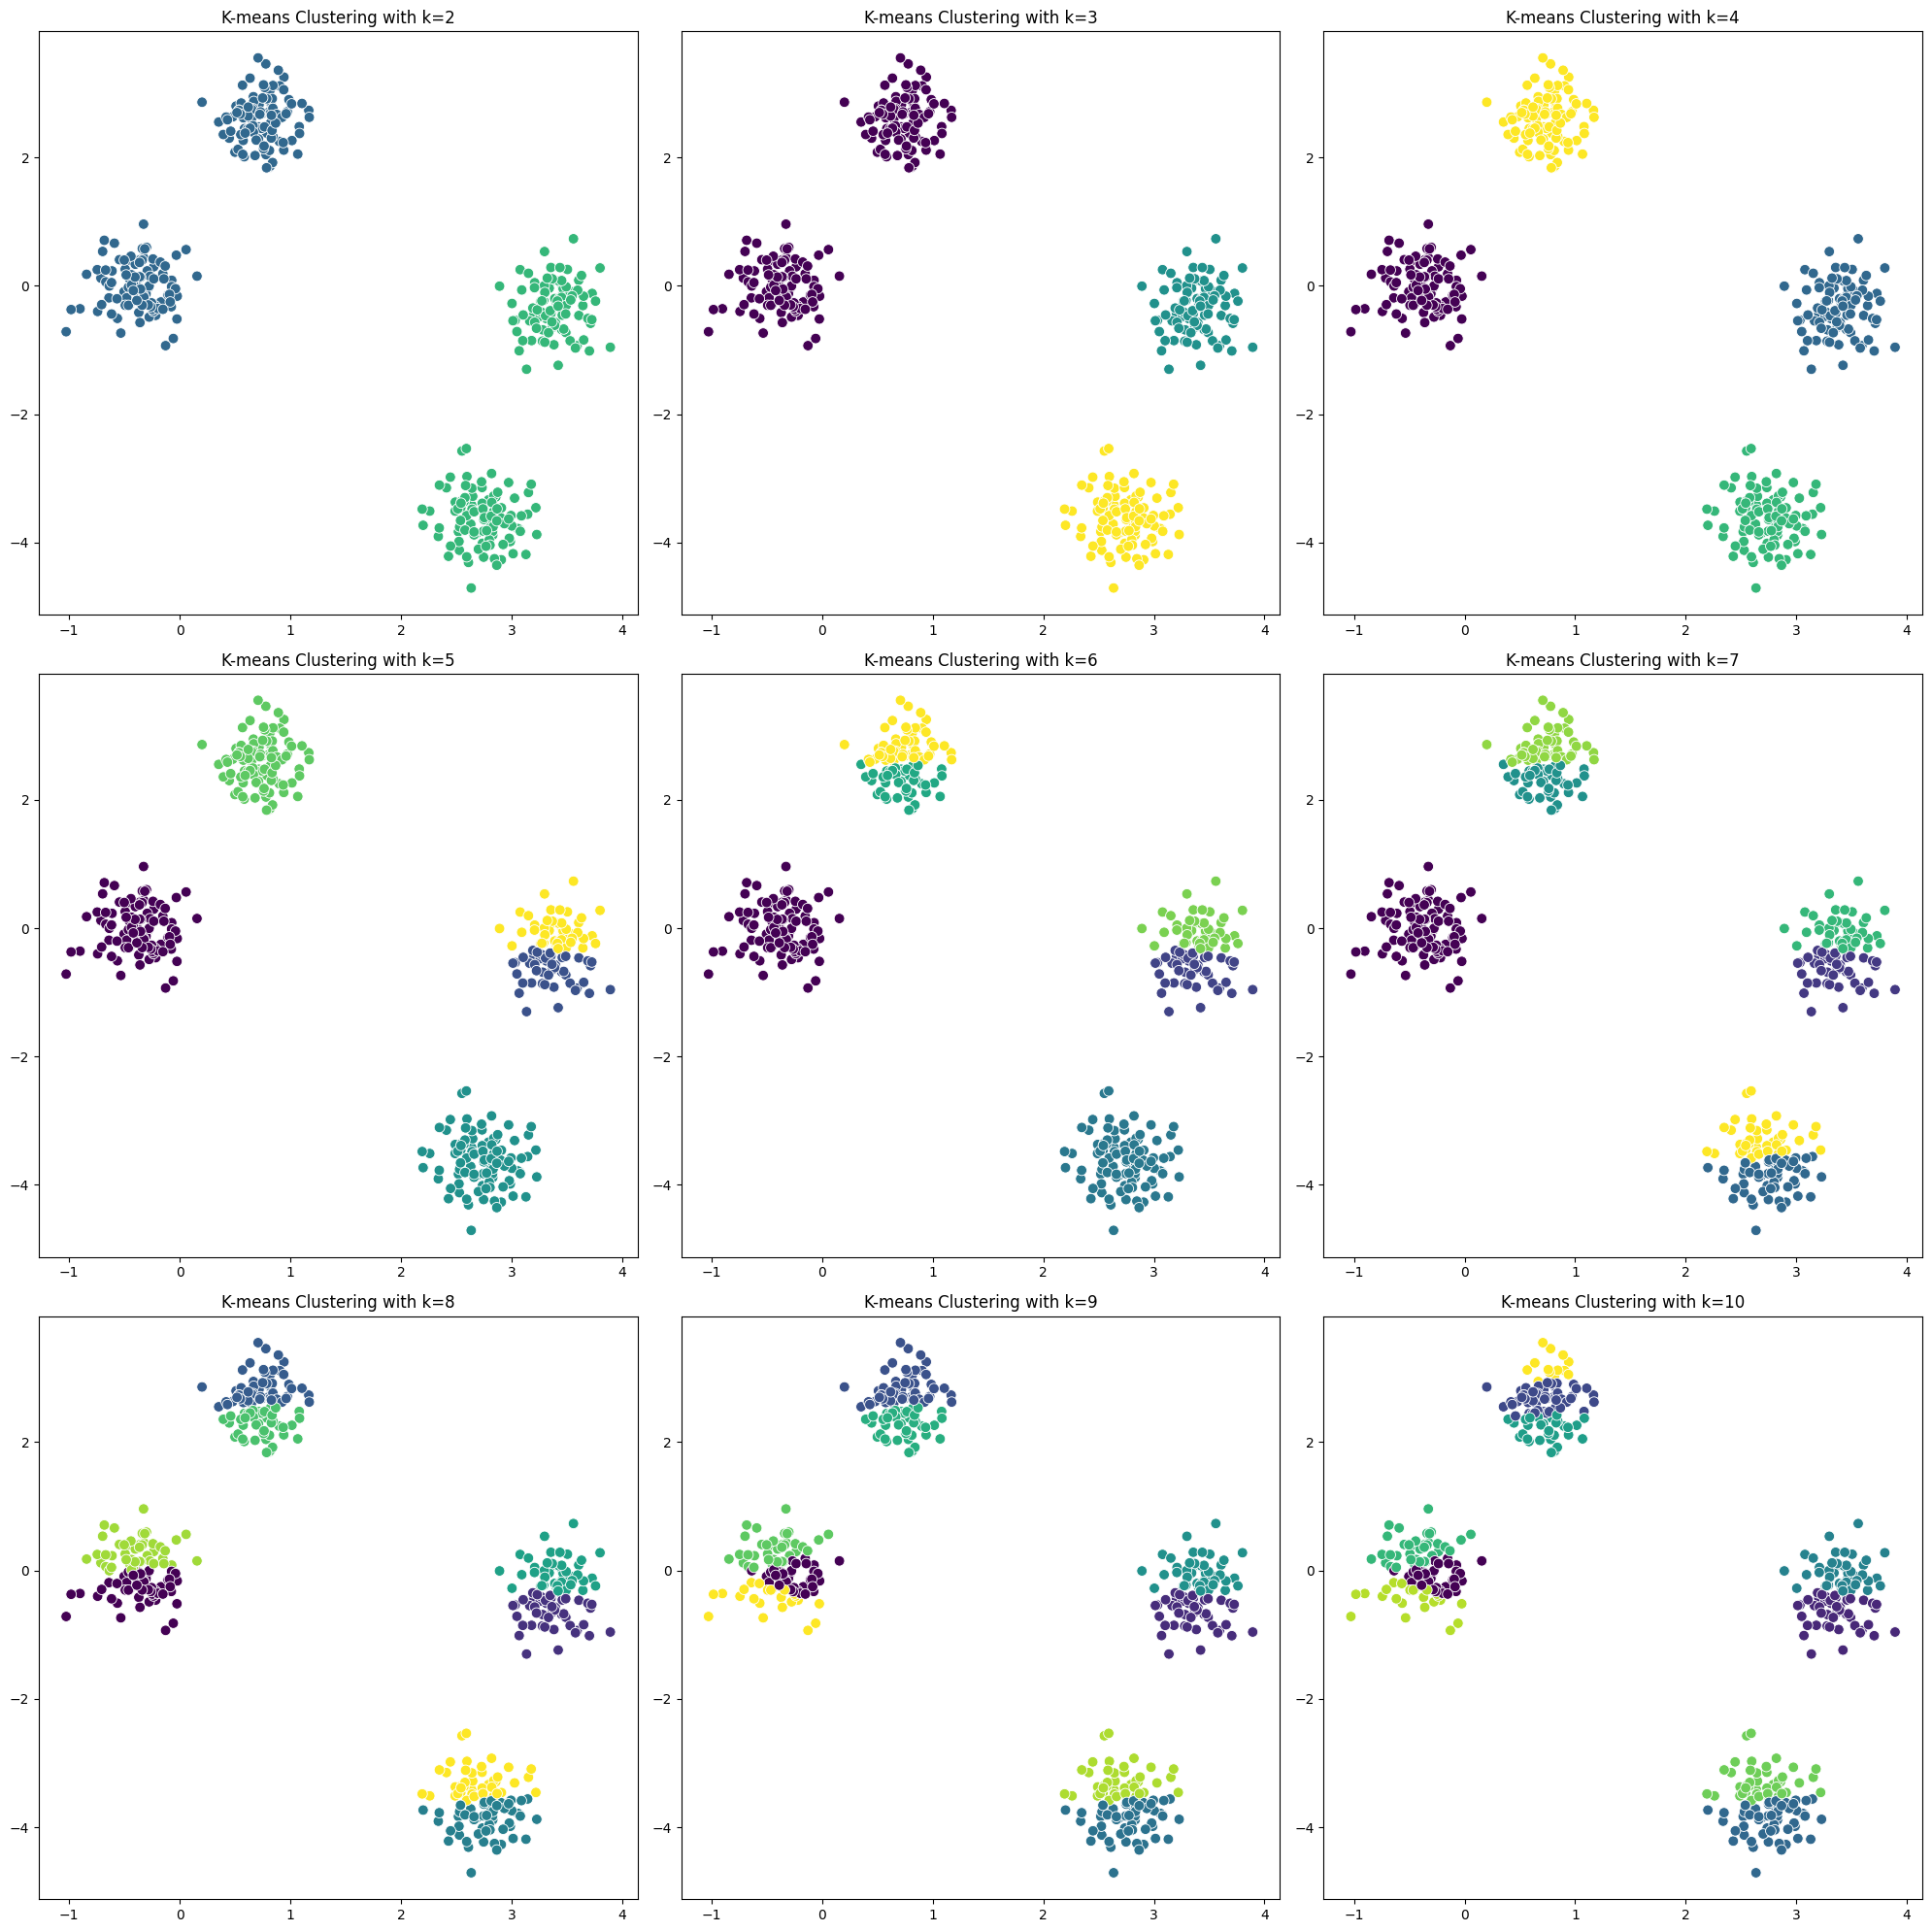

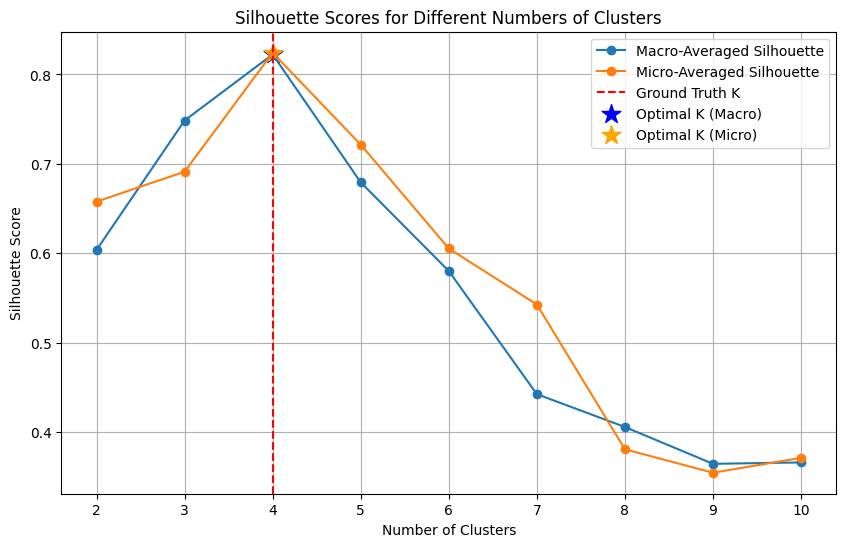

In [237]:
# Remove 100 points from cluster labeled as 1
remove_cluster_label = 1
remove_indices = np.where(y == remove_cluster_label)[0][:1900]
X_ = np.delete(X, remove_indices, axis=0)
y_ = np.delete(y, remove_indices, axis=0)

# Find the optimal number of clusters using silhouette method
mas_, mas_k_, mis_, mis_k_, kmeans_labels_list_ = find_optimal_clusters(X_)

# Plot the data space with different cluster assignments for all K values tested
plt.figure(figsize=(20, 20))
n_plots = len(kmeans_labels_list_)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

for i, (n_clusters, kmeans_labels) in enumerate(kmeans_labels_list_):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=X_[:, 0], y=X_[:, 1], hue=kmeans_labels, palette='viridis', s=60, legend=None)
    plt.title(f'K-means Clustering with k={n_clusters}')

plt.tight_layout()
plt.show()

# Plot the silhouette scores for different numbers of clusters
mas_clusters, mas_values = zip(*mas_)
mis_clusters, mis_values = zip(*mis_)

plt.figure(figsize=(10, 6))
plt.plot(mas_clusters, mas_values, marker='o', label='Macro-Averaged Silhouette')
plt.plot(mis_clusters, mis_values, marker='o', label='Micro-Averaged Silhouette')
plt.axvline(x=centers, color='r', linestyle='--', label='Ground Truth K')

# Plot star on the optimal number of clusters
plt.scatter([mas_k_], [max(mas_values)], color='blue', marker='*', s=200, label='Optimal K (Macro)')
plt.scatter([mis_k_], [max(mis_values)], color='orange', marker='*', s=200, label='Optimal K (Micro)')

plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(mas_clusters)
plt.legend()
plt.grid(True)
plt.show()

# Sampled and Averaged Silhouette

In [101]:
x_mic_s, x_mac_s, added_points = [], [], range(100, 5000, 100)
for ap in added_points:
    X_expanded_grad, y_labels_expanded_grad = add_points_to_cluster(X, y_labels, cluster_to_expand, ap, variance)
    x_mic_s.append(SampleSilhouette(X_expanded_grad, y_labels_expanded_grad, sample_size=100, sample_strategy='micro').macro())
    x_mac_s.append(SampleSilhouette(X_expanded_grad, y_labels_expanded_grad, sample_size=100, sample_strategy='macro').macro())

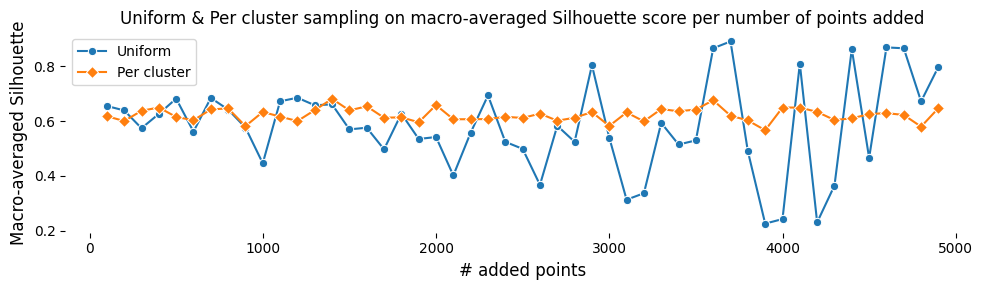

In [102]:
plt.figure(figsize=(10, 3))
sns.lineplot(x=added_points, y=x_mic_s, marker='o', label='Uniform')
sns.lineplot(x=added_points, y=x_mac_s, marker='D', label='Per cluster')
plt.legend()
plt.xlabel('# added points', fontsize=12)
plt.ylabel('Macro-averaged Silhouette', fontsize=12)
plt.title('Uniform & Per cluster sampling on macro-averaged Silhouette score per number of points added')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('expanded_clusters_sampling.jpg', format='JPG', dpi=300)
plt.show()

# Real-world datasets
* Loaded well-known real-world datasets of varying imbalance.
* Applied KMeans at the ground-truth number of clusters.
* Showing that Macro is positively correlated with external measures (NMI, AMI, ARI) while Micro is not.

In [162]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, fetch_20newsgroups, fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to fetch datasets
def get_datasets():
    datasets_list = [
        ('Iris', load_iris(), 'Sepal and petal measurements of iris flowers from three different species.', 'Numeric'),
        ('Wine', load_wine(), 'Chemical analysis of wines grown in the same region in Italy but derived from three different cultivars.', 'Numeric'),
        ('Digits', load_digits(), 'Images of handwritten digits from 0 to 9.', 'Image'),
        ('Covertype', fetch_openml(name='covertype', version=1, parser='auto'), 'Forest cover type from cartographic variables.', 'Numeric'),
        ('Mice Protein', fetch_openml(name='MiceProtein', version=4, parser='auto'), 'Protein expression levels measured in the cortex of normal and trisomic mice who have been exposed to different experimental conditions.', 'Numeric'),
        ('Gas Sensor', fetch_openml(name='gas-drift', version=1, parser='auto'), 'Gas sensor array drift dataset, containing measurements of 16 different gas sensors.', 'Time-series'),
        ('Pendigits', fetch_openml(name='pendigits', version=1, parser='auto'), 'Pen-based handwritten digits.', 'Time-series'),
        ('Glass', fetch_openml(name='glass', version=1, parser='auto'), 'Chemical compositions of glass samples to classify them into 7 types of glass.', 'Numeric'),
        #('TCGA', fetch_openml(name='TCGA', version=1, parser='auto'), 'Cancer genome atlas samples, with various features describing genetic variations.', 'Genomic'),
        #('20 Newsgroups', fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes')), 'A collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups.', 'Text'),
        #('Reuters-21578', fetch_openml(name='Reuters-21578', version=1, parser='auto'), 'Reuters-21578 text categorization collection, used for document classification.', 'Text')
    ]
    return datasets_list
# Function to preprocess datasets
def preprocess_dataset(data):
    if hasattr(data, 'data'):
        X = data.data
        y = data.target
    else:
        X = data.drop(columns='class')
        y = data['class']
        
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Dimensionality reduction (optional, here we keep the first 10 components for example)
    #pca = PCA(n_components=min(10, X.shape[1]))
    #X = pca.fit_transform(X)
    
    return X, y

# Fetch and preprocess datasets
datasets_list = get_datasets()

In [163]:
# Dictionary to store results
results = {
    'Dataset': [],
    'Type': [],
    'N': [],
    'd': [],
    'k': [],
    'r': [],
    'Macro Silhouette': [],
    'Micro Silhouette': [],
    'NMI': [],
    'ARI': [],
    'AMI': []
}

# Measure imbalance ratio based on ground truth labels
for dataset_name, dataset, description, dtype in datasets_list:
    X, y = preprocess_dataset(dataset)
    unique, counts = np.unique(y, return_counts=True)
    imbalance_ratio = min(counts) / max(counts)
    
    # Apply K-means clustering
    n_clusters = len(unique)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X)
    kmeans_labels = kmeans.labels_
    
    # internal measures
    ssil = SampleSilhouette(X, kmeans_labels)
    macrosil = ssil.macro()
    microsil = ssil.micro()

    # external measures
    nmi = normalized_mutual_info_score(y, kmeans_labels)
    ari = adjusted_rand_score(y, kmeans_labels)
    ami = adjusted_mutual_info_score(y, kmeans_labels)
    
    # Store the results
    results['Dataset'].append(dataset_name)
    results['Type'].append(dtype)
    results['N'].append(len(X))
    results['d'].append(X.shape[1])
    results['k'].append(n_clusters)
    results['r'].append(imbalance_ratio)
    results['Macro Silhouette'].append(macrosil)
    results['Micro Silhouette'].append(microsil)
    results['NMI'].append(nmi)
    results['ARI'].append(ari)
    results['AMI'].append(ami)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Sort the DataFrame by Imbalance Ratio
results_df = results_df.sort_values(by='r', ascending=False)

# Print the results in LaTeX format
latex_table = results_df.to_latex(index=False, column_format='lllrrrrrrrr', header=True, float_format="%.2f")

print(latex_table)

\begin{tabular}{|l|l|l|r|r|r|r|r|r|r|r|}
\toprule
     Dataset &        Type &      N &   d &  k &    r &  Macro Silhouette &  Micro Silhouette &  NMI &  ARI &  AMI \\
\midrule
        Iris &     Numeric &    150 &   4 &  3 & 1.00 &              0.46 &              0.46 & 0.66 & 0.62 & 0.66 \\
      Digits &       Image &   1797 &  64 & 10 & 0.95 &              0.14 &              0.14 & 0.69 & 0.56 & 0.69 \\
   Pendigits & Time-series &  10992 &  16 & 10 & 0.92 &              0.26 &              0.27 & 0.67 & 0.53 & 0.67 \\
Mice Protein &     Numeric &   1080 &  77 &  8 & 0.70 &              0.12 &              0.13 & 0.26 & 0.14 & 0.25 \\
        Wine &     Numeric &    178 &  13 &  3 & 0.68 &              0.29 &              0.28 & 0.86 & 0.88 & 0.86 \\
  Gas Sensor & Time-series &  13910 & 128 &  6 & 0.55 &              0.23 &              0.25 & 0.19 & 0.07 & 0.19 \\
       Glass &     Numeric &    214 &   9 &  6 & 0.12 &              0.22 &              0.32 & 0.32 & 0.17 & 0.29 

/var/folders/kf/zjv8rhl90hj2x1rmd1fjly_80000gp/T/ipykernel_51163/3096906150.py:58: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_df.to_latex(index=False, column_format='|l|l|l|r|r|r|r|r|r|r|r|', header=True, float_format="%.2f")


In [166]:
results_df[['Micro Silhouette', 'Macro Silhouette', 'NMI', 'AMI', 'ARI']].corr('spearman')

,Micro Silhouette,Macro Silhouette,NMI,AMI,ARI
Micro Silhouette,1.000000,0.571429,0.476190,0.476190,0.666667
Macro Silhouette,0.571429,1.000000,0.285714,0.285714,0.476190
NMI,0.476190,0.285714,1.000000,1.000000,0.928571
AMI,0.476190,0.285714,1.000000,1.000000,0.928571
ARI,0.666667,0.476190,0.928571,0.928571,1.000000


# Macro - Micro ~ $r$

* The absolute difference between macro and micro is negatively correlated with the balance ratio $r$.  
* The greater the distance of the two, the likelier it is that the clusters will be imbalanced.

In [171]:
mm = results_df.apply(lambda row: abs(row['Micro Silhouette'] - row['Macro Silhouette']), 1)
pd.DataFrame({'Macro-Micro': mm, 'r':results_df.r}).corr('spearman')

,Macro-Micro,r
Macro-Micro,1.000000,-0.833333
r,-0.833333,1.000000


# Find $k$

In [187]:
# Function to find the optimal number of clusters using silhouette method
def find_optimal_clusters(X, max_clusters=15):
    mas, mis = [], []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        kmeans_labels = kmeans.fit_predict(X)
        ssil = SampleSilhouette(X, kmeans_labels)
        macrosil, microsil = ssil.macro(), ssil.micro()
        #macrosil = SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='macro').macro()
        #microsil = SampleSilhouette(X, kmeans_labels, sample_size=100, sample_strategy='micro').micro()
        mas.append((n_clusters, macrosil))
        mis.append((n_clusters, microsil))
    
    return mas, max(mas, key=lambda x: x[1])[0], mis, max(mis, key=lambda x: x[1])[0]

# Fetch and preprocess datasets
#datasets_list = get_datasets()

# Dictionary to store results
results = {
    'Dataset': [],
    'k(MaS)': [],
    'k(MiS)': [],
    'MaS': [],
    'MiS': []
}

# Determine the optimal number of clusters for each dataset
for dataset_name, dataset, description, dtype in datasets_list:
    X, y = preprocess_dataset(dataset)
    mas, mas_k, mis, mis_k = find_optimal_clusters(X)
    
    # Store the results
    results['Dataset'].append(dataset_name)
    results['k(MaS)'].append(mas_k)
    results['k(MiS)'].append(mis_k)
    results['MaS'].append(mas)
    results['MiS'].append(mis)

results_df = pd.DataFrame(results)

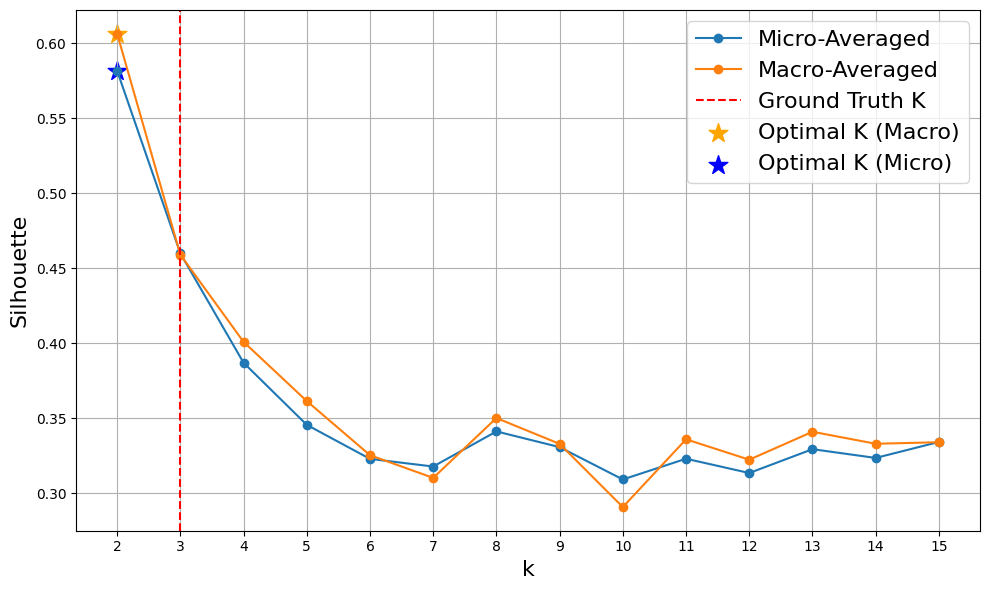

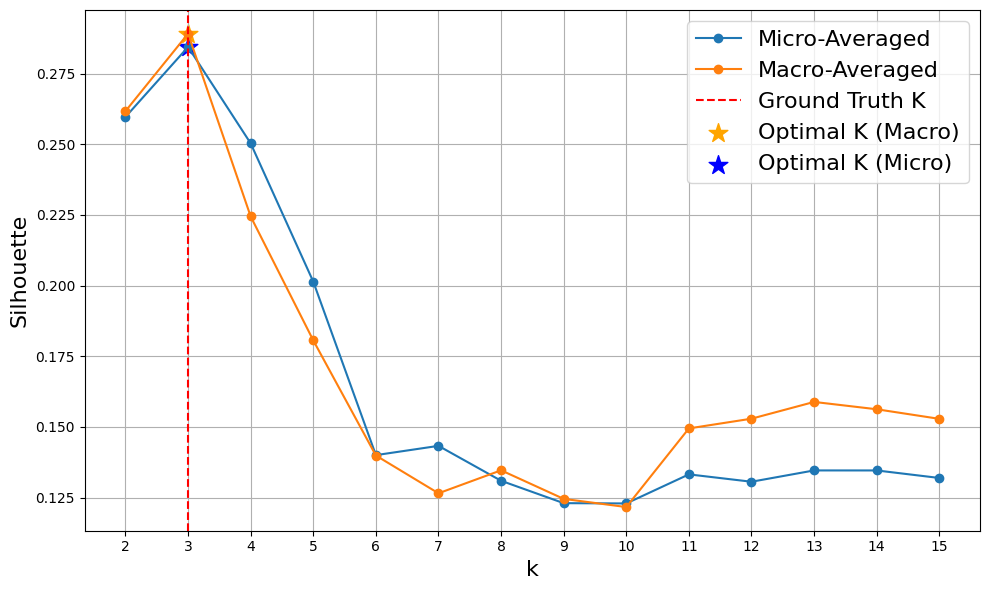

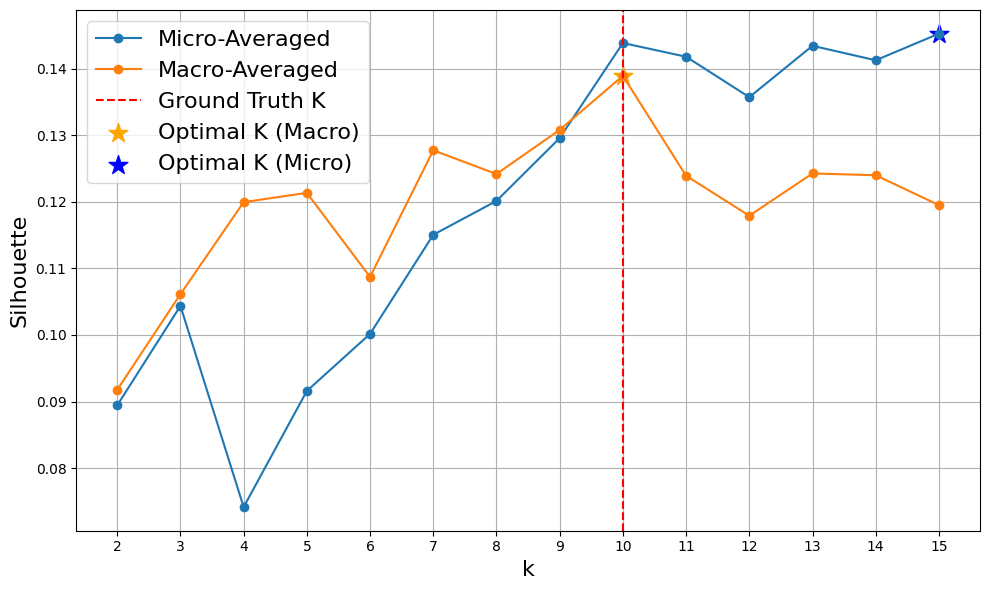

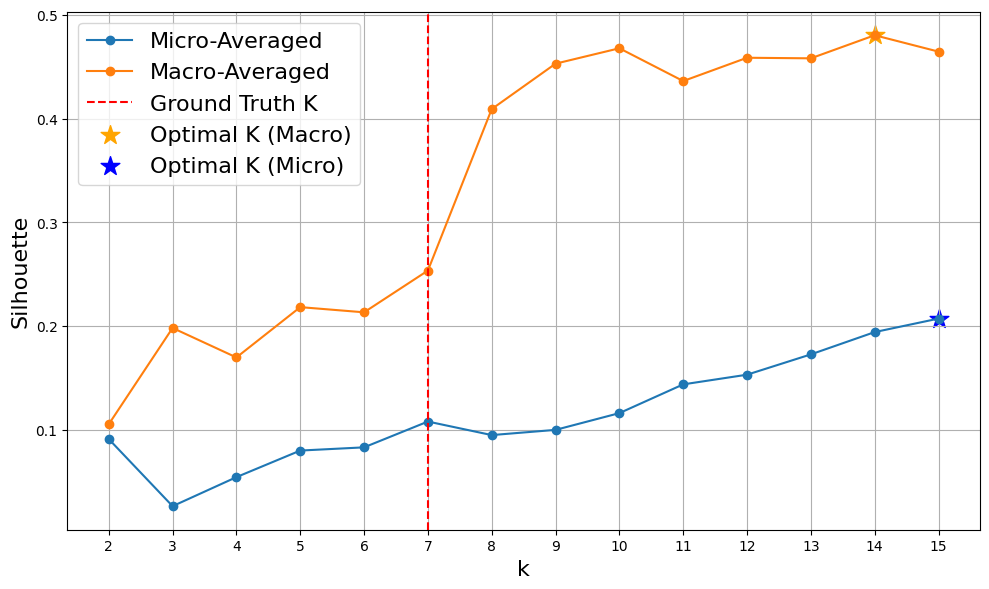

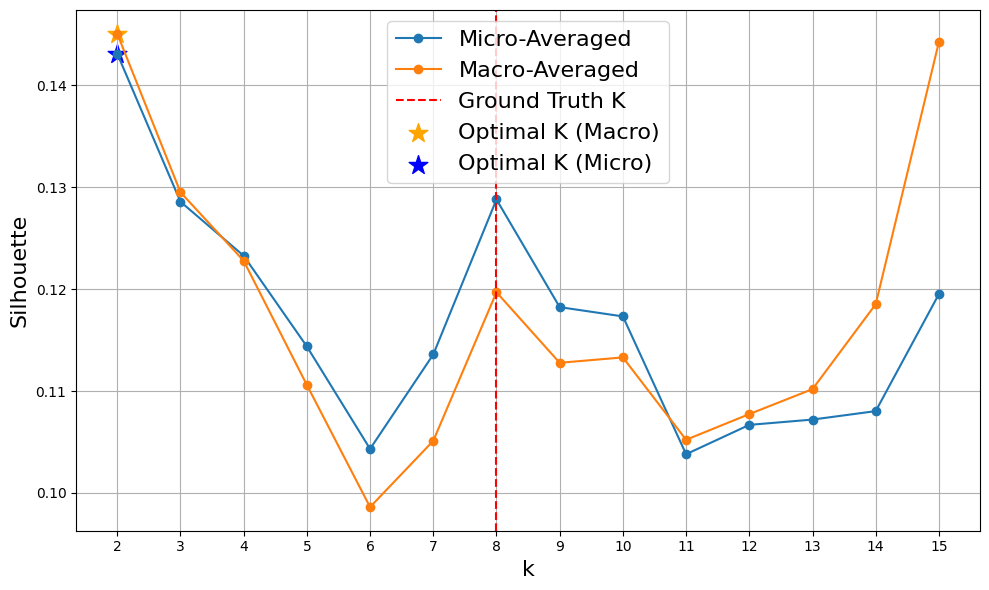

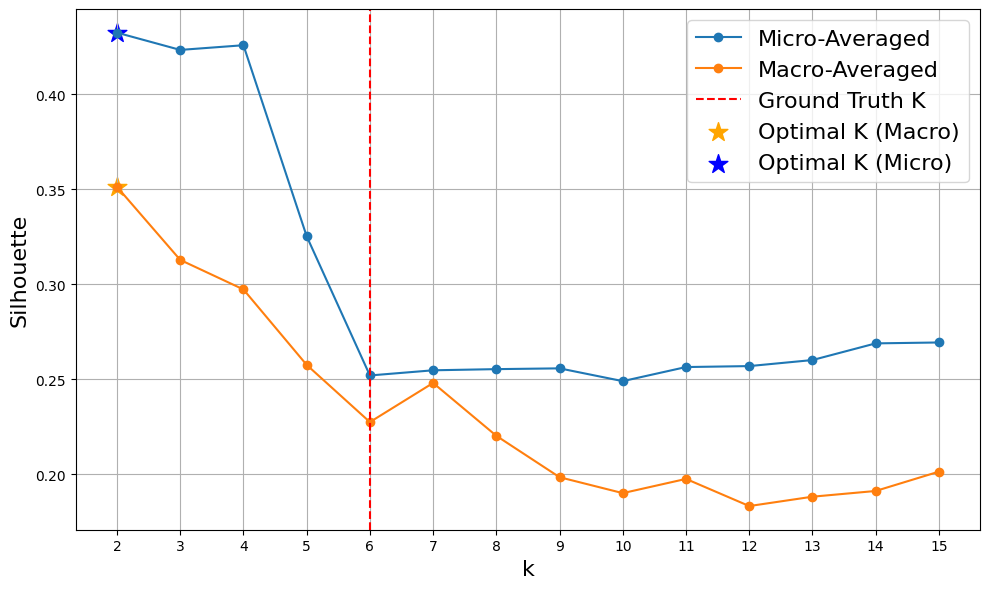

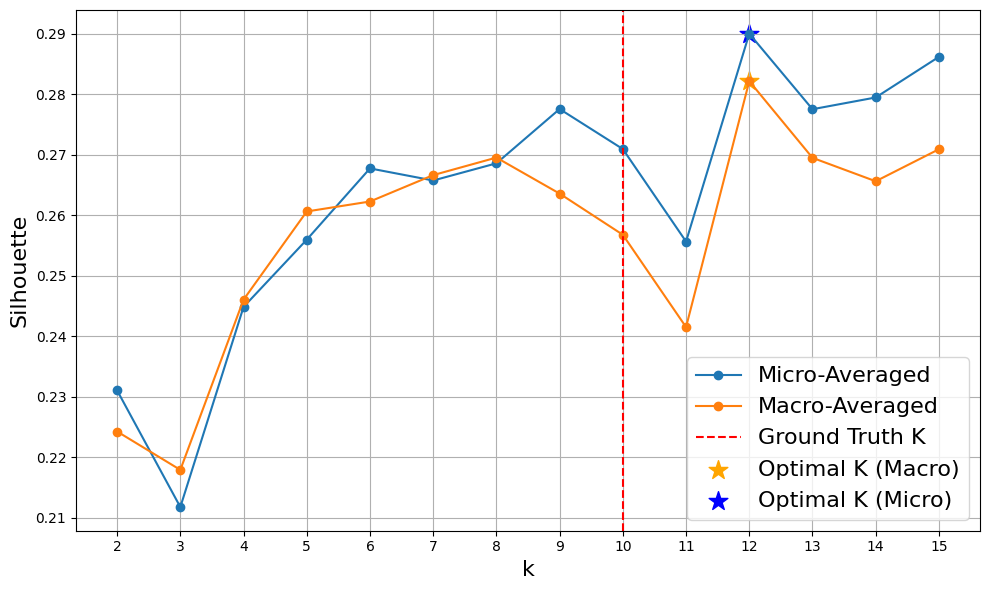

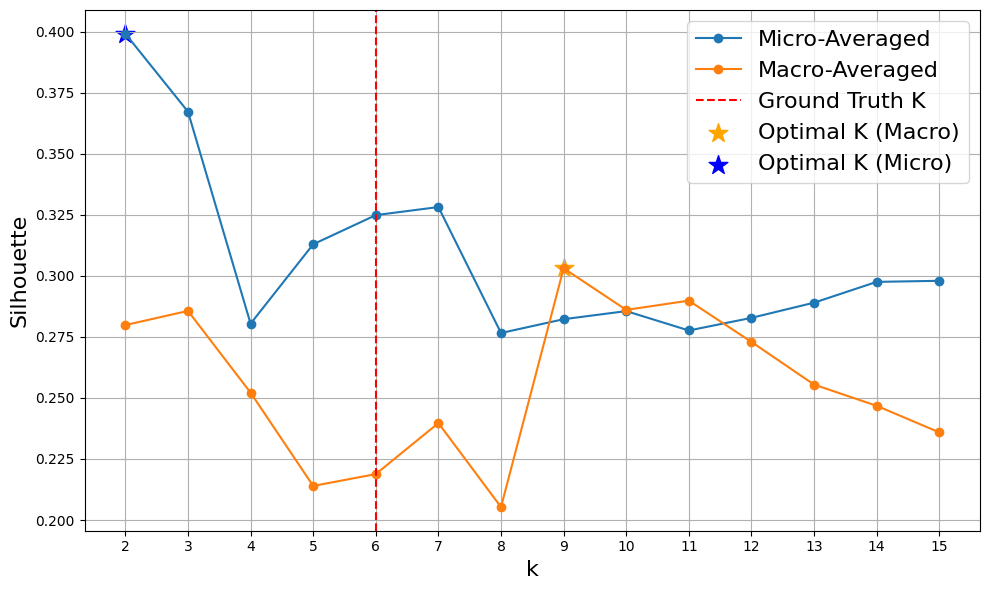

In [198]:
# Plot the silhouette scores for each dataset
for index, row in results_df.iterrows():
    dataset_name = row['Dataset']
    mas_scores = row['MaS']
    mis_scores = row['MiS']
    ground_truth_k = len(np.unique(preprocess_dataset(datasets_list[index][1])[1]))
    
    mas_clusters, mas_values = zip(*mas_scores)
    mis_clusters, mis_values = zip(*mis_scores)
    
    plt.figure(figsize=(10, 6))
    plt.plot(mis_clusters, mis_values, marker='o', label='Micro-Averaged')
    plt.plot(mas_clusters, mas_values, marker='o', label='Macro-Averaged')
    plt.axvline(x=ground_truth_k, color='r', linestyle='--', label='Ground Truth K')
    
    # Plot star on the optimal number of clusters
    plt.scatter([row['k(MaS)']], [max(mas_values)], color='orange', marker='*', s=200, label='Optimal K (Macro)')
    plt.scatter([row['k(MiS)']], [max(mis_values)], color='blue', marker='*', s=200, label='Optimal K (Micro)')
    
    #plt.title(f'Silhouette Scores for Different Numbers of Clusters: {dataset_name}', fontsize=14)
    plt.xlabel('k', fontsize=16)
    plt.ylabel('Silhouette', fontsize=16)
    plt.xticks(mas_clusters)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_optK.jpg', format='JPG', dpi=300)
    plt.show()